# Team 8 (Enchilados MX)
## Solution to IBM's QuantumHack Challenge
* Humberto Barrera Martinez
* Miguel Angel Gonzalez Gutierrez
* Pedro Antonio Gonzalez Soto
* Alejandro Emilio Novales Treviño

The challenge involves creating a program that, utilizing Quantum Computing, determines the optimal route passing through a given set of points. The provided Jupyter Notebook offers a solution to this challenge, employing the TSP Solver with VQA to address each cluster and utilizing KMeans for cluster generation and solving.

The primary code to tackle the challenge is found in the first cell, while the subsequent cells feature test codes used during the development process. For the purpose of understanding and addressing the problem at hand, these test codes can be disregarded.

Our approach to solving this problem involved dividing the entire system of points into n clusters, each containing 4 points. We opted for this approach because when converting the nodes into a matrix, the numpy library struggles to handle matrices with dimensions equal to or larger than 6x6. This limitation influenced our decision, along with the constraint of limited resources for testing, preventing us from applying the TSP solver algorithm to clusters with 5 points due to insufficient RAM.

However, the use of a quantum computer presented a potential solution. Quantum computing allows for more flexible modifications to the cluster sizes through the Kmeans algorithm, leveraging the enhanced processing power to achieve a more efficient classification and solution for each subsystem of points.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


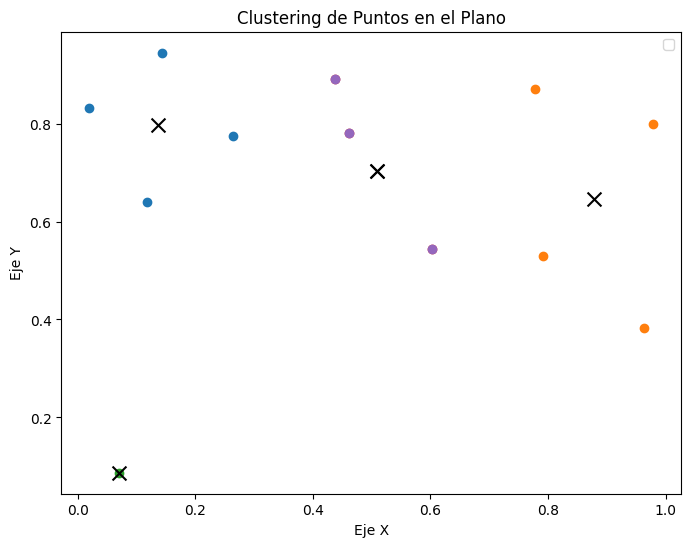

Iteration: 10 , value: (1.0433264665754063+0j)
Iteration: 20 , value: (-2.987153889262208+0j)
Iteration: 30 , value: (-3.069946412050187+0j)
Iteration: 40 , value: (-3.080234896301844+0j)
Iteration: 50 , value: (-3.0866730657775725+0j)
Iteration: 60 , value: (-3.0912701167995507+0j)
Iteration: 70 , value: (-3.095407453720212+0j)
Iteration: 80 , value: (-3.0995133802054924+0j)
Iteration: 90 , value: (-3.1036000979418685+0j)
Iteration: 100 , value: (-3.107657994048468+0j)
solution: [3, 2, 0, 1]
solution objective: 0.7904242196232136
Iteration: 10 , value: (13.502724521556697+0j)
Iteration: 20 , value: (-57.59395950934952+0j)
Iteration: 30 , value: (-58.67940942107802+0j)
Iteration: 40 , value: (-59.699729440117025+0j)
Iteration: 50 , value: (-60.37394901161246+0j)
Iteration: 60 , value: (-61.5688183188764+0j)
Iteration: 70 , value: (-62.51847901324948+0j)
Iteration: 80 , value: (-63.46704941738969+0j)
Iteration: 90 , value: (-63.86600972883639+0j)
Iteration: 100 , value: (-64.33349033261

In [ ]:
#Libraries
import networkx as nx
from qiskit_optimization.applications import Tsp
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.applications import Tsp
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit_optimization import QuadraticProgram
import matplotlib.axes as axes
from qiskit.primitives import Sampler
#from qiskit_ibm_runtime import Sampler as SamplerRT
from qiskit_ibm_runtime import Session
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
#from qiskit_optimization.applications import Maxcut
from qiskit.utils import algorithm_globals

#Login to the IBM Account
service = QiskitRuntimeService(channel="ibm_quantum", token= '')

#Functions for the Program
#Make a function to show the graph (Is not used in this case, but can be used)
def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

#Make a function to show the solution graph (Is not used in this case, but can be used)
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]['weight'])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color='b', node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)

#QAOA Callback function (Check Iterations)
def qaoa_callback(count, params, mean, metadata):
    if count % 10 == 0:
        print('Iteration:', count, ', value:', mean)


#Algoritm KMeans for Clusters
#Random Generation of Points (Locations)
samples=16 #Number of Locations
clusters= int(samples/4)
np.random.seed(0)
X = np.random.rand(samples, 2)

# Generate KMean Model for Cluster Generation
kmeans = KMeans(n_clusters=clusters, random_state=0)
kmeans.fit(X)

#Obtain Clusters Centroid
centroids = kmeans.cluster_centers_
#Assing Points to Cluster
labels = kmeans.labels_

new_clusters = []
#Make Visual Aid
plt.figure(figsize=(8, 6))

#Make Clusters of 4 points(4 as the Maximum nodes for TSP)
for i in range(clusters):
    cluster_points = X[labels == i]
    if len(cluster_points) > 4:
        # Si el cluster tiene más de 4 puntos, selecciona 4 puntos al azar
        m = len(cluster_points)
        cluster_points_res = cluster_points
        while(m>4):
          np.random.shuffle(cluster_points_res)
          cluster_points = cluster_points_res[:3]
          cluster_points_res = cluster_points_res[4:]
          new_clusters.append(cluster_points)
          plt.scatter(cluster_points[:, 0], cluster_points[:, 1])
          plt.scatter(centroids[i, 0], centroids[i, 1], c='black', marker='x', s=100)
          m = m-4
        if(m!=0):
          new_clusters.append(cluster_points)
          plt.scatter(cluster_points[:, 0], cluster_points[:, 1])
          plt.scatter(centroids[i, 0], centroids[i, 1], c='black', marker='x', s=100)
    else :
      new_clusters.append(cluster_points)
      plt.scatter(cluster_points[:, 0], cluster_points[:, 1])
      plt.scatter(centroids[i, 0], centroids[i, 1], c='black', marker='x', s=100)

#Visualization of Clusters in Map
plt.legend()
plt.title('Clustering de Puntos en el Plano')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.show()

soluciones = []

#Algoritm for TSP Solver per Cluster (N-solutions)
for n in range(len(new_clusters)):
  #Create the Network for Cluster N
  points = new_clusters[n] #Takes points from Cluster N
  nop = len(points)
  ntw = nx.Graph()

  for i in range(nop):
    ntw.add_node(i)
  for i in range(nop):
    for j in range(nop):
      point1 = [points[i][0], points[i][1]]
      point2 = [points[j][0], points[j][1]]
      weight = np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)
      ntw.add_edge(i, j, weight = weight)

  tsp = Tsp(ntw) #Convert the Network to Tsp format for Solver
  adj_matrix = nx.to_numpy_array(tsp.graph)

  #Visual Aid for Solution to Cluster N
  '''
  adj_matrix = nx.to_numpy_array(tsp.graph)
  print('distance\n', adj_matrix)
  colors = ['r' for node in tsp.graph.nodes]
  print(tsp.graph.nodes[node]['pos']  for node in tsp.graph.nodes )
  pos = [tsp.graph.nodes[node]['pos']  for node in tsp.graph.nodes]
  draw_graph(tsp.graph, colors, pos)
  '''

  #Solution Algorithm Using VQA (Quantum Computing)
  #Convert the TSP to a quadratic program to use the VQA
  qp = tsp.to_quadratic_program()
  with Session(service = service, backend="ibmq_qasm_simulator") as session: #In this part we select the backend we will be using, in this case we select the simulator
    qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA(maxiter=100), callback=qaoa_callback) #Used if we want to see the iterations per Cluster(callback=qaoa_callback)
    #qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA(maxiter=100))
    qaoa_meo = MinimumEigenOptimizer(qaoa)
    #Compute and Interpret Solution
    qaoa_result = qaoa_meo.solve(qp)

  #Printing Solution to TSP
  #print(qaoa_result) #raw results
  z = tsp.interpret(qaoa_result.x)
  print('solution:', z)
  print('solution objective:', tsp.tsp_value(z, adj_matrix))

  #Solution to Network for Cluster N
  soluciones.append(z)

#Print Cluster Solutions
for i in range(len(soluciones)):
  print(f'Solution for Cluster {i}: {soluciones[i]}')


Since here, code can be ignored (code used for development of main code)

distance
 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]
Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_3 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_3
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_3 + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2
  + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2 + 33*x_0_1*x_3_0 + 33*x_0_1*x_3_2
  + 48*x_0_2*x_1_1 + 48*x_0_2*x_1_3 + 91*x_0_2*x_2_1 + 91*x_0_2*x_2_3
  + 33*x_0_2*x_3_1 + 33*x_0_2*x_3_3 + 48*x_0_3*x_1_0 + 48*x_0_3*x_1_2
  + 91*x_0_3*x_2_0 + 91*x_0_3*x_2_2 + 33*x_0_3*x_3_0 + 33*x_0_3*x_3_2
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_3 + 71*x_1_0*x_3_1 + 71*x_1_0*x_3_3
  + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2 + 71*x_1_1*x_3_0 + 71*x_1_1*x_3_2
  + 63*x_1_2*x_2_1 + 63*x_1_2*x_2_3 + 71*x_1_2*x_3_1 + 71*x_1_2*x_3_3
  + 63*x_1_3*x_2_0 + 63*x_1_3*x_2_2 + 71*x_1_3*x_3_0 + 71*x_1_3*x_3_2
  + 92*x_2_0*x_3_1 + 92*x_2_0*x_3_3 + 92*x_2_1*x_3_0 + 92*x_2_1*x_3_2
  + 92*x_2_2*x_3_1 + 92*x_2_2*x_3_3 + 92*x_2_3*x_3_0 + 92*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 

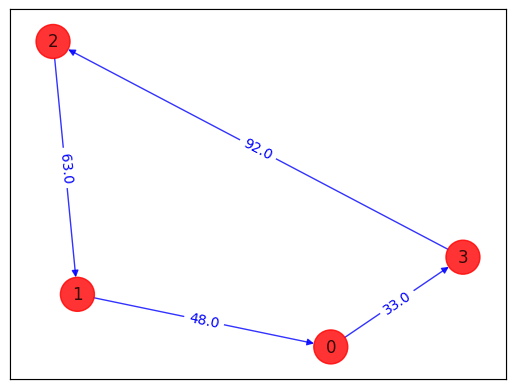

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *  #Library restricted by IBM
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

#Libraries for program
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.applications import Tsp
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit_optimization import QuadraticProgram
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import networkx as nx
from qiskit.primitives import Sampler

#maybe
from qiskit_ibm_runtime import Sampler as SamplerRT
from qiskit_ibm_runtime import Session
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit_optimization.applications import Maxcut
from qiskit.utils import algorithm_globals


#Login to the IBM Account
service = QiskitRuntimeService(channel="ibm_quantum", token= '')

#Functions for the Program

#Make a function to show the graph
def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

#Make a function to show the solution graph
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]['weight'])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color='b', node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)

#QAOA Callback function (Check Iterations)
def qaoa_callback(count, params, mean, metadata):
    if count % 10 == 0:
        print('Iteration:', count, ', value:', mean)

#Generate a the system of points



#Generation of a random system (as an example)

n = 4 #number of points
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print('distance\n', adj_matrix)


#Plot the system
colors = ['r' for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]['pos']  for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

#Convert the TSP to a quadratic program to use the VQA
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

with Session(service = service, backend="ibmq_qasm_simulator") as session:
  qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA(maxiter=100))
  #qaoa = QAOA(sampler=Sampler(), optimizer=COBYLA(maxiter=100), callback=qaoa_callback)
  qaoa_meo = MinimumEigenOptimizer(qaoa)
  #Compute and Interpret Solution
  qaoa_result = qaoa_meo.solve(qp)

print(qaoa_result) #raw results
z = tsp.interpret(qaoa_result.x) #Interpretate solution for better visulization
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, adj_matrix))

#Draw the solution graph
draw_tsp_solution(tsp.graph, z, colors, pos)


In [ ]:
#Machine Learning

from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

X, y = make_classification(
    n_samples=32,
    n_features=2,
    n_classes=8,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=algorithm_globals.random_seed,
)
X = MinMaxScaler().fit_transform(X)

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Genera puntos aleatorios en el plano

samples=1000
clusters= int(1000/4)

np.random.seed(0)
X = np.random.rand(samples, 2)

# Especifica el número de clusters que deseas (en este caso, 10 clusters)
#n_clusters = 10

# Crea un modelo K-Means
kmeans = KMeans(n_clusters=clusters, random_state=0)

# Ajusta el modelo a los datos
kmeans.fit(X)

# Obtiene los centroides de los clusters
centroids = kmeans.cluster_centers_

# Asigna cada punto a un cluster
labels = kmeans.labels_


new_clusters = []
# Visualiza los resultados
plt.figure(figsize=(8, 6))

for i in range(clusters):
    cluster_points = X[labels == i]
    if len(cluster_points) > 4:
        # Si el cluster tiene más de 4 puntos, selecciona 4 puntos al azar
        m = len(cluster_points)
        cluster_points_res = cluster_points
        while(m>4):
          np.random.shuffle(cluster_points_res)
          cluster_points = cluster_points_res[:3]
          cluster_points_res = cluster_points_res[4:]
          new_clusters.append(cluster_points)
          plt.scatter(cluster_points[:, 0], cluster_points[:, 1])
          plt.scatter(centroids[i, 0], centroids[i, 1], c='black', marker='x', s=100)
          m = m-4
        if(m!=0):
          new_clusters.append(cluster_points)
          plt.scatter(cluster_points[:, 0], cluster_points[:, 1])
          plt.scatter(centroids[i, 0], centroids[i, 1], c='black', marker='x', s=100)
    else :
      new_clusters.append(cluster_points)
      plt.scatter(cluster_points[:, 0], cluster_points[:, 1])
      plt.scatter(centroids[i, 0], centroids[i, 1], c='black', marker='x', s=100)

plt.legend()
plt.title('Clustering de Puntos en el Plano')
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.show()
#print(new_clusters)


In [ ]:
#Para cada cluster, obtiene las distancias entre sus puntos y las guarda en una matriz de adyacencia

cluster_graphs = []
for i in range (len(new_clusters)):
  cluster_points = new_clusters[i]
  graph = []
  for i in range (len(cluster_points)):
    graph.append([])
    for j in range (len(cluster_points)):
      graph[i].append(((cluster_points[i][0]-cluster_points[j][0])**2 + (cluster_points[i][1]-cluster_points[j][1])**2)**(1/2))
  cluster_graphs.append(graph)

print(cluster_graphs)